<a target="_blank" href="https://colab.research.google.com/github/taobrienlbl/advanced_earth_science_data_analysis/blob/spring_2023_iub/lessons/04_digging_further_into_data_wrangling/04_estimating_building_height.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This exercise aims to build on your knowledge of the big-four data science libraries to use Kestrel atmospheric measurement devices to estimate the height difference between the ground floor and sixth floor of the Geology building.

# Background

Air pressure monotonically decreases with height in the atmosphere.  This is simply due to the fact that *air pressure is a measure of the weight of everything above*.  So higher up in the atmosphere there is less atmosphere (weight) above, and pressure decreases.

One of the basic principles of fluid dynamics is that a *pressure gradient*--a change in pressure over some distance--exerts a net force on the fluid that, in the absence of other forces, would cause the fluid to move.  So why then does the atmosphere not flow away to space in response to this pressure gradient?

To a very good approximation, the atmosphere is in *hydrostatic balance*, meaning that the vertical pressure gradient is balanced by the force of gravity on the air; gravity effectively negates the pressure gradient force.  This leads to one of the most essential equations in atmospheric science:

$$ \frac{\partial p}{\partial z} = -\rho g$$

where $p$ is the atmospheric pressure, $z$ is height away from the surface, $\rho$ is air density, and $g$ is the gravitational acceleration (we'll use $g \approx 9.806~\text{m s}^{-2}$ here).

If we combine this with the ideal gas law (written in a form that is convenient for atmospheric gasses, where $R_d \approx 287~\text{J kg}^{-1}\text{K}^{-1}$ represents a constant for air with the composition of Earth's atmosphere), we get a differential equation for pressure.

$$\text{Ideal gas law: }~p = \rho R_d T \to $$

$$ \frac{\partial p}{\partial z} = - \frac{p g}{R_d T} $$

We can approximate the derivatives in this equation using finite differences: $\partial p/\partial z \to \Delta p / \Delta z$, where $\Delta$ represents a (presumably small) difference between two pressure or height measurements.  We can then use this to solve for the change in height as a function of changes in pressure:

$$ \Delta z \approx - \frac{R_d T}{g} \frac{\Delta p}{p}$$

# Estimating height

Now imagine that we have a device that records pressure and temperature every second or so.  If you take that device and walk up a set of stairs, the recorded pressure will drop a bit for every second that you're ascending.  A pair of measurements taken at consecutive times can be used to estimate $\Delta p$, and the average of the two measurements can be used to estimate $p$ and $T$ over tha same time frame.  These values can be plugged in to the above formula to estimate the change in height between the two measurements.  The sum of all the changes in height then gives an estimate of the total change in height; we will have numerically integrated the differential equation that comes from combining hydrostatic balance and the ideal gas law.

## Instructions

1. form groups of two or three
1. acquaint yourself with the Kestrel measuring devices, and pair it to at least one of your phones using [Kestrel Link](https://kestrelinstruments.com/link-connectivity)
1. ensure that you can record measurements and export them to csv
1. take the kestrel device down to the ground floor of the Geology building; go to the loop
1. start recording
1. either walk up the stairwell, or take the elevator, up to the 7th floor (you can only access this floor from the western stairwell)
1. end recording
1. export the data to a CSV file and add it to your course git folder (into a folder for lesson 04)
1. estimate the difference in height between the two floors using the method above (*hint*: you should use `pandas`, and you should be able to make a new column for the calculation of $\Delta p$ and $\Delta z$ for each measurement, and then use the `.sum()` method)

*Delete this and insert some initial observations / thoughts for documenting the data analysis process using Markdown*

In [87]:
""" import libraries"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [88]:
# read the data file
df = pd.read_csv('WEATHER_-_2406603_Sep_15_2023_2_56_14_PM.csv',\
                skiprows=[0,1,2,4], \
                usecols=(range(0,16)), \
                parse_dates=[0])
df.head(2)

/var/folders/vr/bxyph_y13z17gzq1r_gst6zw0000gn/T/ipykernel_11711/2438688087.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('WEATHER_-_2406603_Sep_15_2023_2_56_14_PM.csv',\


,FORMATTED DATE_TIME,Temperature,Wet Bulb Temp,Relative Humidity,Barometric Pressure,Altitude,Station Pressure,Wind Speed,Heat Index,Dew Point,Density Altitude,Crosswind,Headwind,Compass Magnetic Direction,Compass True Direction,Wind Chill
0,2023-09-15 14:53:39,70.2,61.2,60.2,29.28,585,29.29,0.0,70.0,55.9,1654,--,--,--,--,70.2
1,2023-09-15 14:53:44,70.3,61.3,61.0,29.28,585,29.29,0.0,70.0,56.2,1659,--,--,--,--,70.2


Text(0.5, 0, 'Time')

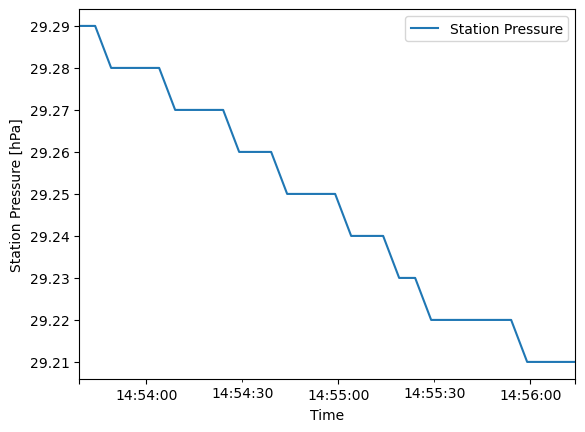

In [89]:
""" Plot a timeseries of the station pressure."""

df.plot(x = "FORMATTED DATE_TIME", y = "Station Pressure");
plt.ylabel("Station Pressure [hPa]")
plt.xlabel("Time")

In [90]:
# pressure data
p = df['Station Pressure']

# calculate pressure change between each data
df['del_p_pa'] = df['Station Pressure'].diff() * 100 # converted to Pa from hPa
df.loc[0,"del_p_pa"] = 0 # 1st value was NaN, set to zero

# calculate average pressure between two consecutive measurement and convert to Pa from hPa
df['avg_delp_pa'] = (df['Station Pressure'] + df['Station Pressure'].shift(1)) * 0.5 * 100
# first value became NaN after the `shift()` operation set the original first value here and into Pa.
df.loc[0, 'avg_delp_pa'] = df.loc[1, 'Station Pressure'] * 100 

# calculate avg temp between each consecutive stations after converting from F to K
df['avg_t_k'] = (((df['Temperature'] + df['Temperature'].shift(1)) * 0.5) - 32) * (5/9) + 273.15
# first value became NaN after the `shift()` operation set the original first value here and into kelvin.
df.loc[0, 'avg_t_k'] = (df.loc[1, 'Temperature'] - 32 ) * (5/9) + 273.15

# check the data now
df



,FORMATTED DATE_TIME,Temperature,Wet Bulb Temp,Relative Humidity,Barometric Pressure,Altitude,Station Pressure,Wind Speed,Heat Index,Dew Point,Density Altitude,Crosswind,Headwind,Compass Magnetic Direction,Compass True Direction,Wind Chill,del_p_pa,avg_delp_pa,avg_t_k
0,2023-09-15 14:53:39,70.2,61.2,60.2,29.28,585,29.29,0.0,70.0,55.9,1654,--,--,--,--,70.2,0.0,2929.0,294.427778
1,2023-09-15 14:53:44,70.3,61.3,61.0,29.28,585,29.29,0.0,70.0,56.2,1659,--,--,--,--,70.2,0.0,2929.0,294.400000
2,2023-09-15 14:53:49,70.2,61.7,62.9,29.28,589,29.28,0.0,70.2,57.0,1666,--,--,--,--,70.2,-1.0,2928.5,294.400000
3,2023-09-15 14:53:54,70.3,62.2,65.0,29.28,592,29.28,0.0,70.2,58.0,1683,--,--,--,--,70.2,0.0,2928.0,294.400000
4,2023-09-15 14:53:59,70.1,62.8,67.3,29.28,594,29.28,0.0,70.2,58.8,1676,--,--,--,--,70.0,0.0,2928.0,294.372222
5,2023-09-15 14:54:04,70.1,63.1,68.6,29.28,597,29.28,0.0,70.2,59.3,1688,--,--,--,--,70.0,0.0,2928.0,294.316667
6,2023-09-15 14:54:09,70.1,63.1,68.3,29.27,600,29.27,0.0,70.2,59.1,1688,--,--,--,--,70.0,-1.0,2927.5,294.316667
7,2023-09-15 14:54:14,70.1,63.0,67.8,29.27,602,29.27,0.0,70.2,58.9,1688,--,--,--,--,70.0,0.0,2927.0,294.316667
8,2023-09-15 14:54:19,70.1,62.8,67.4,29.26,605,29.27,0.0,70.2,58.8,1691,--,--,--,--,70.0,0.0,2927.0,294.316667
9,2023-09-15 14:54:24,70.1,62.6,67.1,29.26,605,29.27,0.0,70.2,58.6,1686,--,--,--,--,70.0,0.0,2927.0,294.316667


In [91]:
""" Calculate the change in height between each measurement. """

# set constants
Rd = 287 # J/kg/K
g = 9.806 # m/s^2

# define other values in the equation for ease of understanding
T = df['avg_t_k']
p = df['avg_delp_pa']
delta_p = df['del_p_pa']

# calculate change in height between two adjacent measeurements
df['delta_h_m'] = - Rd * T * delta_p / (g * p)

df


,FORMATTED DATE_TIME,Temperature,Wet Bulb Temp,Relative Humidity,Barometric Pressure,Altitude,Station Pressure,Wind Speed,Heat Index,Dew Point,Density Altitude,Crosswind,Headwind,Compass Magnetic Direction,Compass True Direction,Wind Chill,del_p_pa,avg_delp_pa,avg_t_k,delta_h_m
0,2023-09-15 14:53:39,70.2,61.2,60.2,29.28,585,29.29,0.0,70.0,55.9,1654,--,--,--,--,70.2,0.0,2929.0,294.427778,-0.000000
1,2023-09-15 14:53:44,70.3,61.3,61.0,29.28,585,29.29,0.0,70.0,56.2,1659,--,--,--,--,70.2,0.0,2929.0,294.400000,-0.000000
2,2023-09-15 14:53:49,70.2,61.7,62.9,29.28,589,29.28,0.0,70.2,57.0,1666,--,--,--,--,70.2,-1.0,2928.5,294.400000,2.942270
3,2023-09-15 14:53:54,70.3,62.2,65.0,29.28,592,29.28,0.0,70.2,58.0,1683,--,--,--,--,70.2,0.0,2928.0,294.400000,-0.000000
4,2023-09-15 14:53:59,70.1,62.8,67.3,29.28,594,29.28,0.0,70.2,58.8,1676,--,--,--,--,70.0,0.0,2928.0,294.372222,-0.000000
5,2023-09-15 14:54:04,70.1,63.1,68.6,29.28,597,29.28,0.0,70.2,59.3,1688,--,--,--,--,70.0,0.0,2928.0,294.316667,-0.000000
6,2023-09-15 14:54:09,70.1,63.1,68.3,29.27,600,29.27,0.0,70.2,59.1,1688,--,--,--,--,70.0,-1.0,2927.5,294.316667,2.942442
7,2023-09-15 14:54:14,70.1,63.0,67.8,29.27,602,29.27,0.0,70.2,58.9,1688,--,--,--,--,70.0,0.0,2927.0,294.316667,-0.000000
8,2023-09-15 14:54:19,70.1,62.8,67.4,29.26,605,29.27,0.0,70.2,58.8,1691,--,--,--,--,70.0,0.0,2927.0,294.316667,-0.000000
9,2023-09-15 14:54:24,70.1,62.6,67.1,29.26,605,29.27,0.0,70.2,58.6,1686,--,--,--,--,70.0,0.0,2927.0,294.316667,-0.000000


In [98]:
""" Sum the changes in height to estimate the total change in height. """

# calculate the total change in height
df['h_m'] = df['delta_h_m'].cumsum()

# total heigt
total_height_m = df['h_m'].iloc[-1]
total_height_ft = total_height_m * 3.28084 # converted to ft
print(f'total height of the building is approx. {total_height_ft} ft or {total_height_m} meter')

print(f'Height of each floor = {total_height_ft/7} ft or, {total_height_m/7} meters')


total height of the building is approx. 77.3265313724425 ft or 23.569126008108444 meter
Height of each floor = 11.046647338920357 ft or, 3.3670180011583493 meters
